In [2]:
# import sys
# sys.path.append("/Assignments/4Assignment_inverse_problems")
import numpy as np
import matplotlib.pyplot as plt
import general_functions as gf
from scipy.optimize import curve_fit


Number of processors: 1, 2, 4, 8, 16, 32, 64, 128

In [3]:
number_of_processors = np.array([1, 2, 4, 8, 16, 32, 64, 128])

In [5]:
# Number of processors to the right
# Measurement repeat down


time_small = np.array([[46.2504, 23.2337, 14.0446, 6.5546, 5.7773],
                    [44.3082, 23.2543, 16.0119, 6.55111, 4.1187],
                    [50.2062, 23.1776, 11.9407, 6.5546, 4.11103],
                    [43.3223, 23.2196, 12.0562, 6.53585, 4.12903]])



time_medium = np.array([[27.9932, 19.0995, 8.90309, 4.37725, 2.75434],
                    [27.9835, 15.1703, 8.06858, 4.3757, 2.69695],
                    [27.9935, 15.168, 9.2084, 4.37169, 3.09369],
                    [27.9811, 19.1235, 9.21886, 4.33398, 2.66883]])


time_large = np.array([[0.776811, 0.744078, 0.766973, 0.737225, 0.746933],
                    [0.768422, 0.719365, 0.76403, 0.766542, 0.763832],
                    [0.720347, 0.703637, 0.744174, 0.761346, 0.741876],
                    [0.710502, 0.684854, 0.741788, 0.738105, 0.735533]])

Get mean, std and relative speedup of data

In [6]:
def error_prop_speedup(t_N_vals, t1, std_t_N_vals, std_t1):
    term1 = std_t1 / t_N_vals
    term2  = -0.5 * t1 / (t_N_vals ** 2) * std_t_N_vals
    std_total = np.sqrt(term1 ** 2 + term2 ** 2)
    return std_total


def abs_and_rel_speedup(data_all, weak_scaling=False):
    # Absolute
    abs_speed_mean = np.mean(data_all, axis=0)
    abs_speed_std = np.std(data_all, axis=0) / np.sqrt((len(abs_speed_mean)-1))  # Bessel's correction
    
    # Relative speedup
    # Divide all data points by the ngangs=1 points.
    t1_vals = data_all[:, 0][:, None]
    std_t1_vals = abs_speed_std[0]
    
    rel_speed_data = t1_vals / data_all  # np.divide(data_all.T, data_all[:, 0]).T
    rel_speed_mean = np.mean(rel_speed_data, axis=0)
    rel_speed_std_all = error_prop_speedup(data_all, t1_vals, abs_speed_std, std_t1_vals)
    rel_speed_std = np.mean(rel_speed_std_all, axis=0)
    if weak_scaling:
         rel_speed_mean *= number_of_gangs
         rel_speed_std *= number_of_gangs
    
    return abs_speed_mean, abs_speed_std, rel_speed_mean, rel_speed_std


# V1
_, _, v1_rel_weak, std_v1_rel_weak = abs_and_rel_speedup(time_v1_weak, weak_scaling=True)
_, _, v1_rel_strong, std_v1_rel_strong = abs_and_rel_speedup(time_v1_strong, weak_scaling=False)

# V3
_, _, v3_rel_weak, std_v3_rel_weak = abs_and_rel_speedup(time_v3_weak, weak_scaling=True)
_, _, v3_rel_strong, std_v3_rel_strong = abs_and_rel_speedup(time_v3_strong, weak_scaling=False)


 #V4
_, _, v4_rel_weak, std_v4_rel_weak = abs_and_rel_speedup(time_v4_weak, weak_scaling=True)
_, _, v4_rel_strong, std_v4_rel_strong = abs_and_rel_speedup(time_v4_strong, weak_scaling=False)


# Plot

#### Fitting

In [7]:
def amdahl_law_theoretical(N_processor, parallel_fraction):
    """Amdahl's law given the number of processors and the fraction of the program that is parallel."""
    S_latency = 1 / ((1 - parallel_fraction) + parallel_fraction / N_processor)
    return S_latency


def gustafs_law_theoretical(N_processor, parallel_fraction):
    speedup = 1 + (N_processor - 1) * parallel_fraction
    return speedup


def fit_scaling(f_fit, time, std_time, p0):
    """_summary_

    Args:
        f_fit (func): Ahmdahls for strong, Gustafs for weak
        time (1darray): Relative time scaling
        std_time (1darray): uncertainty on relative time scaling
        p0 (tupple): Initial guess on parameters

    Returns:
        (par, err, x_fit, y_fit): Fit par, fit err, x values for fit, y values for fit. Last two intended for plotting
    """
    par, cov = curve_fit(f_fit, number_of_gangs, time, sigma=std_time, p0=p0)
    err = np.sqrt(np.diag(cov))
    x_fit = np.linspace(number_of_gangs.min(), number_of_gangs.max(), 300)
    y_fit = f_fit(x_fit, *par)
    return par, err, x_fit, y_fit

In [8]:
# Fit values
# V1
v1_par_strong, err_v1_par_strong, v1_x_fit_strong, v1_y_fit_strong = fit_scaling(amdahl_law_theoretical, v1_rel_strong, std_v1_rel_strong, p0=(0.55, ))
v1_par_weak, err_v1_par_weak, v1_x_fit_weak, v1_y_fit_weak = fit_scaling(gustafs_law_theoretical, v1_rel_weak, std_v1_rel_weak, p0=(0.55, ))

# V3
v3_par_strong, err_v3_par_strong, v3_x_fit_strong, v3_y_fit_strong = fit_scaling(amdahl_law_theoretical, v3_rel_strong, std_v3_rel_strong, p0=(0.65, ))
v3_par_weak, err_v3_par_weak, v3_x_fit_weak, v3_y_fit_weak = fit_scaling(gustafs_law_theoretical, v3_rel_weak, std_v3_rel_weak, p0=(0.65, ))

# V4
v4_par_strong, err_v4_par_strong, v4_x_fit_strong, v4_y_fit_strong = fit_scaling(amdahl_law_theoretical, v4_rel_strong, std_v4_rel_strong, p0=(0.75, ))
v4_par_weak, err_v4_par_weak, v4_x_fit_weak, v4_y_fit_weak = fit_scaling(gustafs_law_theoretical, v4_rel_weak, std_v4_rel_weak, p0=(0.75, ))

### Plot the strong and week scaling together with fits

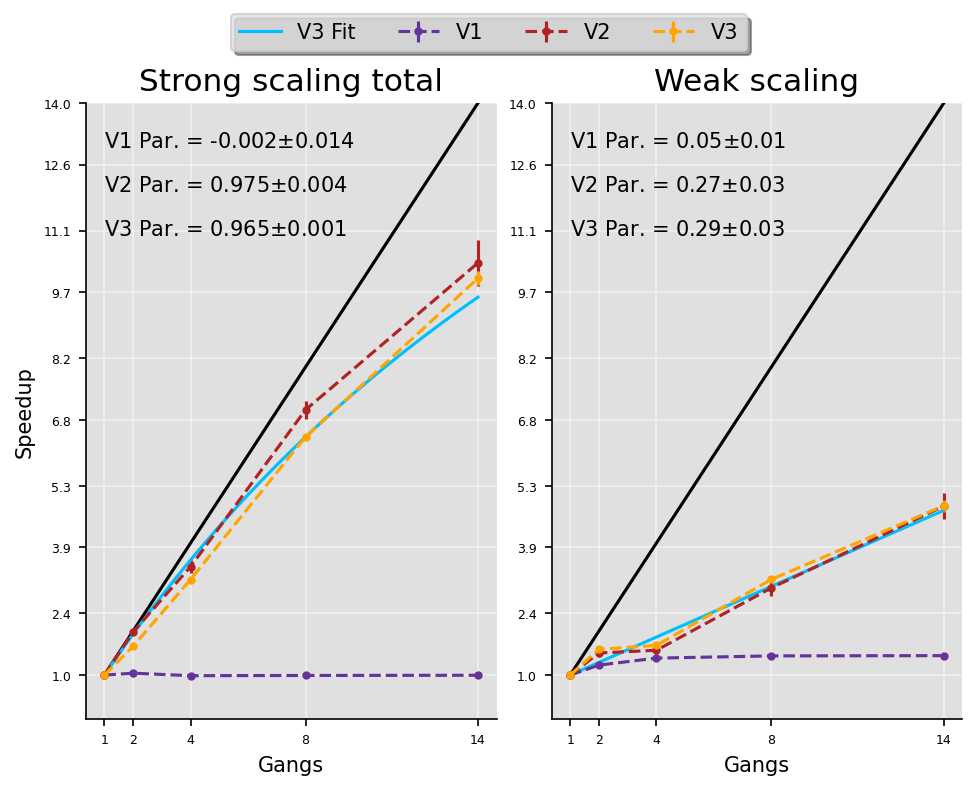

In [13]:
fig, (ax, ax_weak) = plt.subplots(ncols=2)
ylim = (0, number_of_gangs.max())
yticks = np.round(np.linspace(number_of_gangs.min(), number_of_gangs.max(), 10), 1)

# Strong scaling
# Ideal scaling
ax.plot(number_of_gangs, number_of_gangs, ls="-", color="black")
# Data
ax.errorbar(number_of_gangs, v1_rel_strong, yerr=std_v1_rel_strong, fmt=".--", label="V1")
ax.errorbar(number_of_gangs, v3_rel_strong, yerr=std_v3_rel_strong, fmt=".--", label="V2") 
ax.errorbar(number_of_gangs, v4_rel_strong, yerr=std_v4_rel_strong, fmt=".--", label="V3", color="orange",)
# Fit
#ax.plot(v1_x_fit_strong, v1_y_fit_strong, ls="-", c="deepskyblue", label="V1 Fit")
#ax.plot(v3_x_fit_strong, v3_y_fit_strong, ls="-", c="blue", label="V2 Fit")
ax.plot(v4_x_fit_strong, v4_y_fit_strong, ls="-", c="deepskyblue", label="V3 Fit")

ax.set(ylabel="Speedup", xlabel="Gangs", title="Strong scaling total", ylim=ylim)
ax.set_xticks(ticks=number_of_gangs, labels=number_of_gangs, fontsize=6)
ax.set_yticks(ticks=yticks, labels=yticks, fontsize=6)
ax.grid()

# Weak scaling 
# Ideal scaling
ax_weak.plot(number_of_gangs, number_of_gangs, ls="-", color="black")
# Data
ax_weak.errorbar(number_of_gangs, v1_rel_weak, yerr=std_v1_rel_weak, fmt=".--", label="V1")
ax_weak.errorbar(number_of_gangs, v3_rel_weak, yerr=std_v3_rel_weak, fmt=".--", label="V2")
ax_weak.errorbar(number_of_gangs, v4_rel_weak, yerr=std_v4_rel_weak, fmt=".--", label="V3", color="orange")
# Fit
#ax_weak.plot(v1_x_fit_weak, v1_y_fit_weak, ls="-", c="deepskyblue")
#ax_weak.plot(v3_x_fit_weak, v3_y_fit_weak, ls="-", c="blue")
ax_weak.plot(v4_x_fit_weak, v4_y_fit_weak, ls="-", c="deepskyblue")

ax_weak.set(xlabel="Gangs", title="Weak scaling", ylim=ylim)
ax_weak.set_xticks(ticks=number_of_gangs, labels=number_of_gangs, fontsize=6)
ax_weak.set_yticks(ticks=yticks, labels=yticks, fontsize=6)
ax_weak.grid()

# Text results
# Strong scaling text
v1_s_strong = f"V1 Par. = {v1_par_strong[0]:.3f}" + r"$\pm$" + f"{err_v1_par_strong[0]:.3f}"
v3_s_strong = f"V2 Par. = {v3_par_strong[0]:.3f}" + r"$\pm$" + f"{err_v3_par_strong[0]:.3f}"
v4_s_strong = f"V3 Par. = {v4_par_strong[0]:.3f}" + r"$\pm$" + f"{err_v4_par_strong[0]:.3f}"

ax.text(1, 13, v1_s_strong)
ax.text(1, 12, v3_s_strong)
ax.text(1, 11, v4_s_strong)

# Weak scaling text
v1_s_weak = f"V1 Par. = {v1_par_weak[0]:.2f}" + r"$\pm$" + f"{err_v1_par_weak[0]:.2f}"
v3_s_weak = f"V2 Par. = {v3_par_weak[0]:.2f}" + r"$\pm$" + f"{err_v3_par_weak[0]:.2f}"
v4_s_weak = f"V3 Par. = {v4_par_weak[0]:.2f}" + r"$\pm$" + f"{err_v4_par_weak[0]:.2f}"

ax_weak.text(1, 13, v1_s_weak)
ax_weak.text(1, 12, v3_s_weak)
ax_weak.text(1, 11, v4_s_weak)

# Legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=6)

fig.savefig("task2_scaling.png")
plt.show()